In [9]:
import argparse
import glob
import logging
import os
import os.path as osp
import json
import shutil

from torch.jit import Error

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm

from dataset.dataset import Receipt
from model import BERTxSAGE
from utils import LABELS
from utils.metrics import MetricTracker

In [14]:
torch.manual_seed(42)

if True:
    torch.cuda.set_device(3)
    torch.cuda.manual_seed(42)

test_files = glob.glob("/mnt/disk1/doan/vaipe-hiepnm/receipt-ai/funsd_dataset/dataset/testing_data/anno/*.json")

test_dataset = Receipt(test_files)
print(f"Number of test set: {len(test_dataset)}")

Number of test set: 50


In [11]:
model = BERTxSAGE()
model = torch.load("./logs/saved_funsd/model_best.pth")
# if args.cuda:
    # Move model to GPU.
model.cuda()
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTxSAGE

In [15]:
test_loader = DataLoader(test_dataset, batch_size=8)
y_trues = []
y_preds = []
for data in tqdm(test_loader, desc="Test"):
    data = data.cuda()
    print(data)
    with torch.no_grad():
        output = model(data)            # sum up batch loss
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        pred.squeeze_()
        y_trues.append(data.y.cpu().numpy())
        y_preds.append(pred.cpu().numpy())
y_preds = np.concatenate(y_preds)
y_trues = np.concatenate(y_trues)

Test:   0%|          | 0/7 [00:00<?, ?it/s]


ValueError: 'question' is not in list

In [5]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_trues, y_preds)

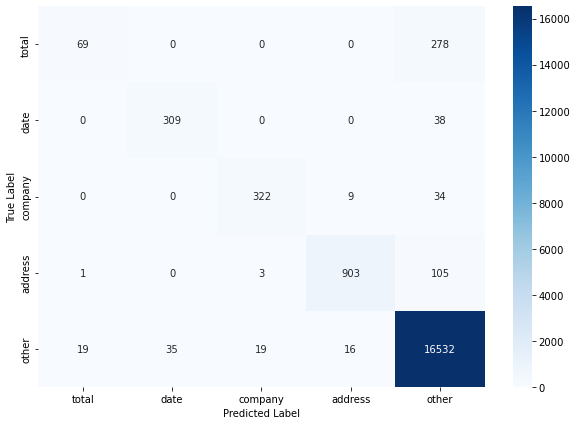

In [6]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted Label'
plt.figure(figsize = (10,7))
sns_plot = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [7]:
from sklearn.metrics import classification_report
cr = classification_report(y_trues, y_preds,
                            target_names=LABELS, zero_division=0)

In [8]:
print(cr)

              precision    recall  f1-score   support

       total       0.78      0.20      0.32       347
        date       0.90      0.89      0.89       347
     company       0.94      0.88      0.91       365
     address       0.97      0.89      0.93      1012
       other       0.97      0.99      0.98     16621

    accuracy                           0.97     18692
   macro avg       0.91      0.77      0.81     18692
weighted avg       0.97      0.97      0.97     18692

